In [2]:
#installed packages;
!pip install networkx==3.4.2
!pip install matplotlib
!pip install ijson
!pip install -qU langchain[openai]
!pip install -qU langchain_community
!pip install langgraph
!pip install nx-arangodb
!pip install -U langchain-groq
!pip install nx-cugraph-cu12 --extra-index-url https://pypi.nvidia.com
!pip install adbnx-adapter
!pip install gradio
!pip install gitingest
!pip install uuid


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.2/119.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.4/415.4 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.5/131.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 100.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.6/114.6 kB 13.

In [1]:
import os
import base64
import re
import logging
import random
import matplotlib.pyplot as plt
import ijson
import uuid


from google.colab import userdata
import networkx as nx
import nx_cugraph as nxcg
import nx_arangodb as nxadb
from arango import ArangoClient
from adbnx_adapter import ADBNX_Adapter, ADBNX_Controller
from adbnx_adapter.typings import NxId, NxData
from langgraph.prebuilt import create_react_agent
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain.prompts import PromptTemplate
from langchain_core.tools import tool
from langchain_community.chains.graph_qa.arangodb import ArangoGraphQAChain
from langchain_community.graphs.arangodb_graph import ArangoGraph
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import StructuredTool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, MessagesState, StateGraph, END
import gradio as gr
from gradio import ChatMessage
from gitingest import ingest_async
import subprocess
import logging
import math
import requests
import time

[21:09:51 +0000] [INFO]: NetworkX-cuGraph is available.
INFO:nx_arangodb:NetworkX-cuGraph is available.


In [136]:
# os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")

os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY_2")


In [3]:
logger = logging.getLogger()

logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(message)s",
    filename="app.log",
    filemode="a"
)
logger.setLevel(logging.INFO)

In [4]:
%env NX_CUGRAPH_AUTOCONFIG=True
nx.config.backends.arangodb.use_gpu = True
nx.config.backend_priority = ["cugraph"]
programmingLanguageDict = {
    "c#": "c_sharp", # to avoid clashing with the arangodb key nameing conventions
}


env: NX_CUGRAPH_AUTOCONFIG=True


In [96]:
encodedCA = userdata.get("SIGNATURE")
try:
    file_content = base64.b64decode(encodedCA)
    with open("cert_file.crt", "w+") as f:
        f.write(file_content.decode("utf-8"))
except Exception as e:
    print(str(e))
    exit(1)

client = ArangoClient(
      hosts=userdata.get("DATABASE_HOST"), verify_override="cert_file.crt"
)

  # Connect to the correct database
db = client.db(
    userdata.get('DATABASE_NAME'),
    username=userdata.get("DATABASE_USERNAME"),
    password=userdata.get("DATABASE_PASSWORD")
)

In [6]:
def sanitiseText(text):

    if text is None:
        return None

    pattern = r'[^A-Za-z0-9_\-\.@()+,=;$!*\'%]'
    text = re.sub(pattern, '_', text)

    return text.lower().strip()


Nodes are structured in the following format with the **key** attribute as an additional property:

- **Forked as a main node**  
  1. **Repo** (stars, forks, repoLink, description)  
  2. **Owner**  
  3. **Language**  
  4. **Topic**

### Edges:  
1. **Repo** ⟷ **Owner**  
2. **Repo** ⟷ **Languages**  
3. **Repo** ⟷ **Topic**  
4. **Repo** ⟷ **Forked**  
5. **Owner** ⟷ **Language**
6. **Owner** ⟷ **Topic**

In [7]:
repoCounter = 0;
languagesCounter = 0
topicCounter = 0
ownerCounter = 0

def addToNetworkxNode(row, Graph):

          global repoCounter, languagesCounter, topicCounter, ownerCounter
          repoName = sanitiseText(row["name"])
          if repoName is not None and repoName:
              repoNodeKey = f"repository-{repoName}"
              if not Graph.has_node(repoNodeKey):
                  repoCounter+=1
                  Graph.add_node(repoNodeKey, type="repository", stars=row["stars"], forks=row["forks"], key=repoNodeKey, repoLink=row["nameWithOwner"], description = row["description"], size= row["diskUsageKb"], createdDate = row["createdAt"])

          owner = sanitiseText(row["owner"])
          if owner is not None and owner:
              ownerNodeKey = f"owner-{owner}"
              if not Graph.has_node(ownerNodeKey):
                  ownerCounter+=1
                  Graph.add_node(ownerNodeKey, type="owner", key=ownerNodeKey)
              if not Graph.has_edge(repoNodeKey, ownerNodeKey):
                  Graph.add_edge(repoNodeKey, ownerNodeKey, relation="owner")

          if row["isFork"]:
              Graph.add_edge(repoName, "forked", relation="isForkRepo")


          for topic in row.get("topics", []):

              topicName = sanitiseText(topic.get("name", None))
              if topicName is not None and topicName:
                  topicNodeKey = f"topic-{topicName}"
                  if not Graph.has_node(topicNodeKey):
                      topicCounter+=1
                      Graph.add_node(topicNodeKey, type="topic", key=topicNodeKey)
                  if not Graph.has_edge(repoNodeKey, topicNodeKey):
                      Graph.add_edge(repoNodeKey, topicNodeKey, relation="topic")
                  if Graph.has_edge(ownerNodeKey, topicNodeKey):
                      Graph[ownerNodeKey][topicNodeKey]["weight"] = Graph[ownerNodeKey][topicNodeKey].get("weight", 0) + 1
                  else:
                      Graph.add_edge(ownerNodeKey, topicNodeKey, weight=1, relation="contribute")


          filePercentage = sum(map(lambda lang: lang["size"], row["languages"] if row["languages"] is not None else []))
          for proLang in row["languages"]:
              proLangName = proLang.get("name", None)
              if proLangName is not None and proLangName:
                  if proLangName in programmingLanguageDict:
                        proLangName = programmingLanguageDict[proLangName]
                  proLangName = sanitiseText(proLangName)
                  proLangSize = proLang.get("size", 0)
                  proLangNodeKey = f"language-{proLangName}"
                  if not Graph.has_node(proLangNodeKey):
                      languagesCounter+=1
                      Graph.add_node(proLangNodeKey, type="language", key=proLangNodeKey)
                  if not Graph.has_edge(repoNodeKey, proLangNodeKey):
                      percentage = math.floor((proLangSize / filePercentage) * 100 if filePercentage else 0)
                      Graph.add_edge(repoNodeKey, proLangNodeKey, relation="language", percent_used = percentage, size = proLangSize)

                  if Graph.has_edge(ownerNodeKey, proLangNodeKey):
                      Graph[ownerNodeKey][proLangNodeKey]["weight"] = Graph[ownerNodeKey][proLangNodeKey].get("weight", 0) + 1
                  else:
                      Graph.add_edge(ownerNodeKey, proLangNodeKey, weight=1, relation="used")

In [94]:
print(repoCounter)
print(languagesCounter)
print(topicCounter)
print(ownerCounter)

3204210
588
523973
1460611


In [8]:
def createNetworkxGraph()-> nx.Graph:
    file_path = "/content/drive/MyDrive/repo_metadata.json" ## file path of the data to be processed

    G = nx.Graph()

    with open(file_path, 'r') as f:
        parser = ijson.items(f, 'item')
        logger.info("Creating Graph")
        G.add_node("forked", type="isFork", key="forked")
        for row in parser:

          repo_info = {
                'name': row['name'],
                'owner': row['owner'],
                'nameWithOwner': row['nameWithOwner'],
                'isFork': row['isFork'],
                'description': row['description'],
                'stars': row['stars'],
                'forks': row['forks'],
                "createdAt": row["createdAt"],
                "diskUsageKb": row["diskUsageKb"],
                "topics": row["topics"],
                "languages": row["languages"],

            }


          addToNetworkxNode(repo_info, G)


        return G






In [9]:
def plotGraph(G):
  logger.info("Plotting graph")
  G_sample = G.subgraph(list(G.nodes)[:100000])
  plot_options = {"node_size": 2, "with_labels": False, "width": 0.02}
  pos = nx.spring_layout(G_sample, iterations=2, seed=1721)  # Use sample graph
  fig, ax = plt.subplots(figsize=(8, 6))
  nx.draw_networkx(G_sample, pos=pos, ax=ax, **plot_options)
  plt.show()

In [10]:
def plotSubGraph(G):
  logger.info("Plotting subgraph")
  G_sample = G.subgraph(list(G.nodes)[:5000])
  plot_options = {"node_size": 2, "with_labels": False, "width": 0.02}
  pos = nx.spring_layout(G_sample, iterations=5, seed=1721)  # Use sample graph
  fig, ax = plt.subplots(figsize=(15, 9))
  nx.draw_networkx(G_sample, pos=pos, ax=ax, **plot_options)
  plt.show()

In [11]:
def uploadNetworkGraphIntoArangodb(G):

  class CustomController(ADBNX_Controller):
      def _keyify_networkx_node(
          self, i: int, nx_node_id: NxId, nx_node: NxData, col: str
      ) -> str:
          return (nx_node.get("key", str(uuid.uuid4())));

      def _prepare_networkx_edge(self, nx_edge: dict, col: str) -> None:
          from_node = nx_edge.get("_from", "")
          to_node = nx_edge.get("_to", "")

          if "repository" in from_node or "repository" in to_node:
              if "repository" not in from_node:
                  nx_edge["_from"], nx_edge["_to"] = to_node, from_node
          elif "owner" in from_node or "owner" in to_node:  # Ensuring owner swap happens only if repository condition wasn't met
              if "owner" not in from_node:
                  nx_edge["_from"], nx_edge["_to"] = to_node, from_node


  adbnx_adapter = ADBNX_Adapter(db, CustomController())

  edge_definitions = [
      {
          'edge_collection': 'Github_node_to_Github_node',
          'from_vertex_collections': ['Github_node'],
          'to_vertex_collections': ['Github_node']
      }
  ]

  adb_g = adbnx_adapter.networkx_to_arangodb(userdata.get("GRAPH_NAME"), G, edge_definitions, batch_size=9000)



In [90]:
def createNetworkxArangoDBGraph():
  graph = createNetworkxGraph()
  plotGraph(graph)
  plotSubGraph(graph)
  uploadNetworkGraphIntoArangodb(graph)

[19:13:52 +0000] [INFO]: Graph 'Github' exists.
INFO:nx_arangodb:Graph 'Github' exists.
[19:13:52 +0000] [INFO]: Default node type set to 'Github_node'
INFO:nx_arangodb:Default node type set to 'Github_node'
INFO:root:Creating Graph
INFO:root:Plotting graph


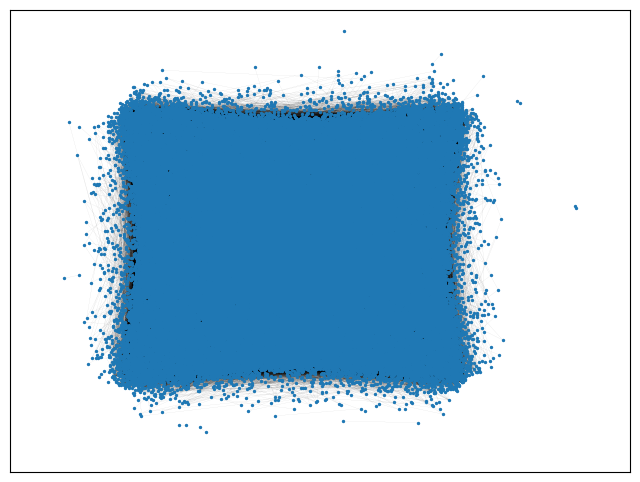

INFO:root:Plotting subgraph


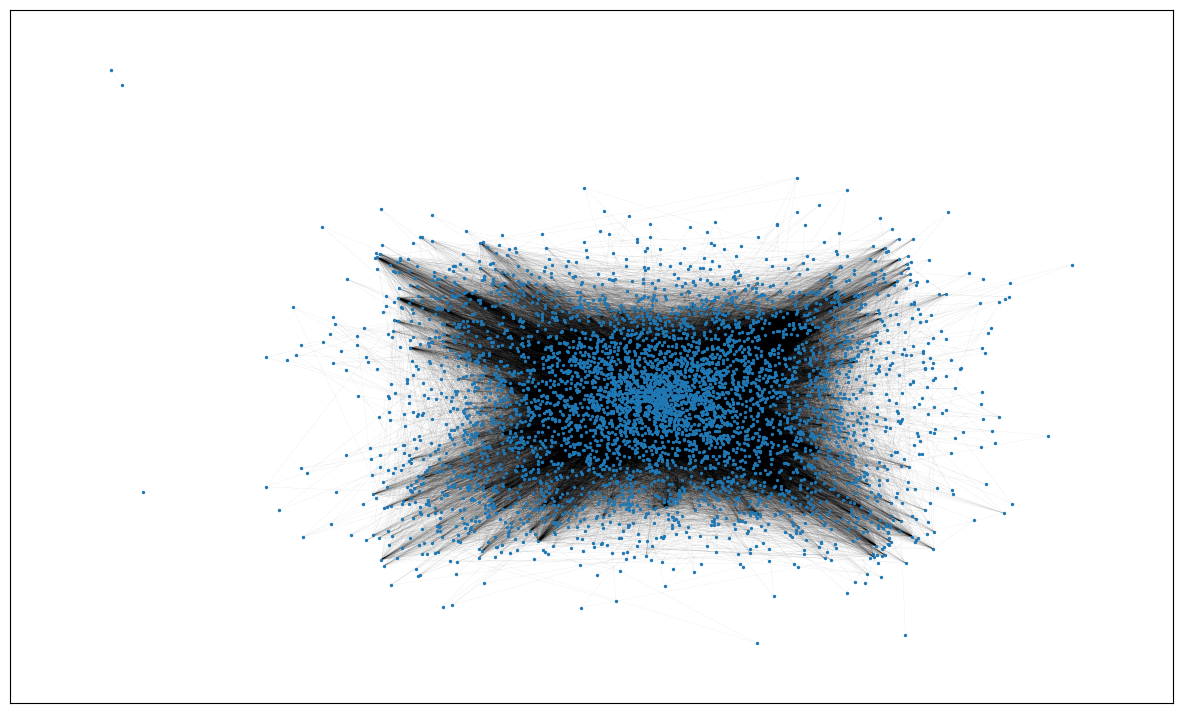

In [23]:
G_adb = nxadb.Graph(name=userdata.get("GRAPH_NAME"), db=db)

if G_adb.number_of_nodes() == 0:
  createNetworkxArangoDBGraph()
else:
  logger.info("Graph is already loaded")


In [97]:
G_adb = nxadb.Graph(name=userdata.get("GRAPH_NAME"), db=db)

if G_adb.number_of_nodes()==0:
  createNetworkxArangoDBGraph()
else:
  logger.info("Graph is already loaded")


[01:20:12 +0000] [INFO]: Graph 'Github' exists.
INFO:nx_arangodb:Graph 'Github' exists.
[01:20:12 +0000] [INFO]: Default node type set to 'Github_node'
INFO:nx_arangodb:Default node type set to 'Github_node'
INFO:root:Graph is already loaded


In [13]:
arangooGraph = ArangoGraph(db)

In [14]:
from pydantic import BaseModel, Field
from typing import List

class Outputresponse(BaseModel):
    """Respond to the user in this format."""
    type: str = Field(description="response type either text")
    text: str = Field(description="response for the user query in simple text")

class OutputList(BaseModel):
    responses: List[Outputresponse] = Field(description="List of Outputresponse objects")


In [162]:
@tool
def humanQueryToAQL(query: str):
    """This tool is available to invoke the
    ArangoGraphQAChain object, which enables you to
    translate a Natural Language Query into AQL, execute
    the query, and translate the result back into Natural Language.
    If user has any questions or interested in anything related to topics, or repository information like language, stars, author , use this tool, to convert into AQL and extract the information\

    If the query requires use of networkx algorithms, just return the nodes and edges, dont compute the algoirhtm
    """

    logger.info("Executing Human Query to AQL %s", query)
    query = sanitiseText(query)

    llm = ChatOpenAI(temperature=0.5, model_name="gpt-4o")


    aql_generation_prompt = PromptTemplate(
    input_variables=['adb_schema', 'aql_examples', 'user_input'],
    template="""Task: Generate an ArangoDB Query Language (AQL) query from a User Input.

You are an ArangoDB Query Language (AQL) expert responsible for translating a `User Input` into an ArangoDB Query Language (AQL) query. Your query should be in way which can return the nodes and edges for the given query, so i can create subgraph for it if needed

You are given an `ArangoDB Schema`. It is a JSON Object containing:
1. `Graph Schema`: Lists all Graphs within the ArangoDB Database Instance, along with their Edge Relationships.
2. `Collection Schema`: Lists all Collections within the ArangoDB Database Instance, along with their document/edge properties and a document/edge example.

You may also be given a set of `AQL Query Examples` to help you create the `AQL Query`. Make sure to keep in mind how the nodes, attributes, and edges are structured in order to generate the query.

Nodes/Edges are structured in format:
repoNodeKey = repository-repoName
G.add_node(repoNodeKey, type='repository', stars=row['stars'], forks=row['forks'], key=repoNodeKey, repoLink=row['nameWithOwner'], description = row['description'], size= row['diskUsageKb'])
ownerNodeKey = owner-ownerName
G.add_node(ownerNodeKey, type='owner', key=ownerNodeKey)
topicNodeKey = topic-topicName
G.add_node(topicNodeKey, type='topic', key=topicNodeKey)
proLangNodeKey = language-programmingLanguageName
G.add_edge(repoNodeKey, ownerNodeKey, relation='owner')
G.add_edge(repoName, 'forked', relation='isForkRepo')
G.add_edge(repoNodeKey, topicNodeKey, relation='topic')
G.add_edge(repoNodeKey, proLangNodeKey, relation='language', percent_used = percentage, size)
G.add_edge(ownerNodeKey, topicNodeKey, weight=weight , relation="used")


Use the format defined to generate the AQL query.

If provided, the `AQL Query Examples` should be used as a reference, similar to how `ArangoDB Schema` should be used.

Things you should do:
- Think step by step.
- Rely on `ArangoDB Schema` and `AQL Query Examples` (if provided) to generate the query.
- Begin the `AQL Query` with the `WITH` AQL keyword to specify all required ArangoDB Collections.
- Return the `AQL Query` wrapped in three backticks (```)
- Use only the provided relationship types and properties in the `ArangoDB Schema` and any `AQL Query Examples`.
- Only answer requests related to generating an AQL Query.
- If a request is unrelated to generating an AQL Query, say that you cannot help the user.
- For every query, return the repoLink for sure.
- Query related to majorly, always try to include relevant metrics if you have it
- All the query should be in lowercase and if it contains spaces replace it with - for example web extension should be web-extension,
- Always return all the neighbours and make query according to it so i can use to create subgraph and execute networkx algorithms for it
- Also for all the url returned make sure, valid github url is returned, if needed,  include the domain and protocol along with repoLink Field from attributes EX: https://github.com/repoLink which is present from repo attribute
- If it contains strings like c# replace it with c_sharp
- If the query contains multiple different queries (topics, repos, languages), use different queries and retrieves those results accordingly.

Things you should not do:
- Always just return the AQL Result without processing for human format


Things you should not do:
- Do not use any properties/relationships that can't be inferred from the `ArangoDB Schema` or the `AQL Query Examples`.
- Do not include any text except the generated AQL Query.
- Do not provide explanations or apologies in your responses.
- Do not generate an AQL Query that removes or deletes any data.
- Do not generate an AQL Query which us gonna compute networkx algorithms on the graph.
- Do not process the AQL Result for human readble message



Under no circumstances should you generate an AQL Query that deletes any data.

ArangoDB Schema:
{adb_schema}

AQL Query Examples (Optional):
{aql_examples}

User Input:
{user_input}

AQL Query:
"""
)

    graph = ArangoGraph(db)

    chain = ArangoGraphQAChain.from_llm(
    llm=llm,
    graph=graph,
    aql_generation_prompt=aql_generation_prompt,
    verbose=True,
    allow_dangerous_requests=True,
    max_aql_generation_attempts=3,
    return_aql_result=True,
    aql_examples="""
Example 1:
WITH Github_node, Github_node_to_Github_node
FOR owner IN Github_node
  FILTER owner.type == "owner" AND owner.key == "owner-freecodecamp"
  FOR edge IN Github_node_to_Github_node
    FILTER edge._to == owner._id AND edge.relation == "owner"
    FOR repo IN Github_node
      FILTER repo._id == edge._from AND repo.type == "repository"
    LIMIT 5
    RETURN repo


"""
)

    logger.info("Executing Human Query to AQL")

    result = chain.invoke(query)

    return str(result)

In [143]:
@tool
def executeNetworkxAlgorithms(query:str, nodes:str):
    """This tool is designed to handle queries requiring NetworkX algorithms (such as similarity scores, PageRank, etc.) on an ArangoDB Graph which you retrieve. It processes natural language queries, and responsible for creating a subgraph from the nodes you received and applies the necessary graph algorithm. The results are then translated into natural language to match the original query.

       Use this tool for graph-based computations, including similarity scores, ranking, and connectivity analysis. If the query is on the lines of compute score or similarity or if needs any use of networkx algorithms, use this tool

       Pass the query as well as the nodes and egdes
    """

    logger.info("Executing NetworkX Algorithm")
    logger.info("Executing query %s", query)
    logger.info("Node Datastructure %s", nodes)

    llm = ChatOpenAI(temperature=0, model_name="gpt-4o", verbose=True)

    logger.info("1) Generating NetworkX code")

         # TODO: Consider experimenting with a code corrector!
    attempt = 1
    MAX_ATTEMPTS = 3
    isExecutionSuccessful = False
    query = f"""
            I have a list of information from which you can create a graph Graph called `G_nx`. The data is present in the {nodes}

            Create a graph with the below schema:

            Nodes/Edges should be structured in format:
            repoNodeKey = repository-repoName
            G.add_node(repoNodeKey, type='repository', stars=row['stars'], forks=row['forks'], key=repoNodeKey, repoLink=row['nameWithOwner'], description=row['description'], size=row['diskUsageKb'])
            ownerNodeKey = owner-ownerName
            G.add_node(ownerNodeKey, type='owner', key=ownerNodeKey)
            topicNodeKey = topic-topicName
            G.add_node(topicNodeKey, type='topic', key=topicNodeKey)
            proLangNodeKey = language-programmingLanguageName
            G.add_edge(repoNodeKey, ownerNodeKey, relation='owner')
            G.add_edge(repoName, 'forked', relation='isForkRepo')
            G.add_edge(repoNodeKey, topicNodeKey, relation='topic')
            G.add_edge(repoNodeKey, proLangNodeKey, relation='language', percent_used=percentage, size=size)
            G.add_edge(ownerNodeKey, topicNodeKey, weight=weight, relation=used)

            I have the following graph analysis query: {query}.

            All the information like programming language and everything would be in lowercase, so generate according to that.

            Generate the Python Code required to create a network graph from the {nodes} and execute the networkx algorithm `G_adb` object.

            Be very precise on the NetworkX algorithm you select to answer this query. Think step by step.

            Only assume that networkx is installed, and other base python dependencies.

            import nx_adb for running on GPU also add this to run on GPU: nx.config.backends.arangodb.use_gpu = True and also use the below options

            ```Sample code:

            import networkx as nx
            import nx_cugraph as nxcg
            import nx_arangodb as nxadb

            os.environ["NX_CUGRAPH_AUTOCONFIG"] = "True"
            nx.config.backends.arangodb.use_gpu = True
            nx.config.backend_priority = ["cugraph"]

            # Convert the ArangoDB graph to a GPU-accelerated graph
            G_nx = nx.Graph()
            nx.pagerank(G_nx)
            ```

            Always set the last variable as `FINAL_RESULT`, which represents the answer to the original query.

            Only provide python code that I can directly execute via `exec()`. Do not provide any instructions.

            Make sure that `FINAL_RESULT` stores a short & concise answer. Avoid setting this variable to a long sequence.

            If error in code, print the error message, so generate code accordinlgy

            Your code:
            """

    while attempt <= MAX_ATTEMPTS and not isExecutionSuccessful:
        try:
            # Your LLM invocation to generate graph code
            text_to_nx = llm.invoke(query).content

            text_to_nx_cleaned = re.sub(r"^```python\n|```$", "", text_to_nx, flags=re.MULTILINE).strip()

            logger.info('-'*10)
            logger.info("Executing Code %s", text_to_nx_cleaned)
            logger.info('-'*10)


            # ######################

            logger.info("\n2) Executing NetworkX code")

            global_vars = {"G_adb": G_adb, "nx": nx}
            local_vars = {}

            exec(text_to_nx_cleaned, global_vars, local_vars)

            text_to_nx_final = text_to_nx
            isExecutionSuccessful = True

        except Exception as e:
            logging.info(f"EXEC ERROR: {e} ")
            attempt += 1
            query += f"""\n Executing the code {text_to_nx_cleaned} Recieved the error message {e}"""




    FINAL_RESULT = local_vars["FINAL_RESULT"]
    print("2) Final resukt networkx code")

    logger.info("3) Formulating final answer %s", FINAL_RESULT)

    nx_to_text = llm.invoke(f"""
        I have a NetworkX Graph called `G_adb`. It has the following schema: {arangooGraph.schema}

        I have the following graph analysis query: {query}.

        I have executed the following python code to help me answer my query:

        ---
        {text_to_nx_final}
        ---

        The `FINAL_RESULT` variable is set to the following: {FINAL_RESULT}.

        Based on my original Query and FINAL_RESULT, generate a short and concise response to
        answer my query.

        Your response:
    """).content

    logger.info(f"Final Answer: %s", nx_to_text)

    return nx_to_text


In [144]:
@tool
def fetchGithRepo(query: str):
    """This tool is used if there is no repository information present in AQL database or in the networkx graph as a fallback option. Execute this tool to provide information about the repo and pass the repo name or just the metadata to the tool"""

    logger.info("Executing Fetch GitHub Repo %s", query)
    search_url = 'https://api.github.com/search/repositories'
    search_params = {
        'q': query,
        'per_page': 10,
        'page': 1
    }

    search_response = requests.get(search_url, params=search_params)

    if search_response.status_code == 200:
        search_data = search_response.json()
        repo_details = []

        for repo in search_data.get('items', []):
            repo_info = {
                'name': repo['name'],
                'owner': repo['owner']['login'],
                'nameWithOwner': repo['full_name'],
                'isFork': repo['fork'],
                'description': repo['description'],
                'stars': repo['stargazers_count'],
                'forks': repo['forks_count'],
                "createdAt": repo["created_at"],
                "diskUsageKb": repo["size"]

            }

            languages_url = repo['languages_url']
            languages_response = requests.get(languages_url)
            if languages_response.status_code == 200:
                languages = languages_response.json()
                languages_info = []

                for language, size in languages.items():
                    languages_info.append({"name": language, "size": size})

                repo_info['languages'] = languages_info
            else:
                repo_info['languages'] = []

            topic_info = []
            for topic in repo.get("topics", []):
                topic_info.append({"name": topic})

            repo_info['topics'] = topic_info
            repo_details.append(repo_info)

            addToNetworkxNode(repo_info, G_adb);



    logger.info("Repo Details: %s", repo_details)
    return repo_details


In [ ]:
@tool
def gitIngest(query):
    """
       This tool is used to parse a repository, extracting its file structure and summary, tokens within files. Invoke this tool when a user requests information about the repository's contents or file structure or tokens or summary of the repo

       Invoke this repo, if summary, tokens or file structure is asked
    """
    logger.info("Tool Executing  == GitIngest")
    try:
      command = f"gitingest {query}"
      result = subprocess.run(command, shell=True, check=True, text=True, capture_output=True)
      output = result.stdout

      parts = output.split("Summary:", 1)
      before_summary = parts[0].strip()
      summary_part = "Summary:" + parts[1] if len(parts) > 1 else ""

      return {"summary": summary_part}
    except:
      logger.error("Error in Extracting File strcuture")
      return ""

In [182]:
tools = [gitIngest, executeNetworkxAlgorithms, humanQueryToAQL, fetchGithRepo ]
memory = MemorySaver()
def processRag(query:str):
    """
    Processes a user query and returns the response.
    """

    logger.info("Executing Query %s", query)
    prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a helpful bot named octorag, basically a RAG chatbot who helps users understand GitHub repos
        You have around information about the repos, which was collected by running a webscrapper from github.
        When you need to decide between multiple tools, think your actions carefully before choosing and use chain of thought to decide between tools
        Break down the actions from user query into action items and decide between which tools to use and pass the necessary details according to the tools need
        """),
        ("placeholder", "{messages}"),
    ])

    model = ChatOpenAI(temperature=0, model_name="gpt-4o", verbose=True)

    model_with_tools = model.bind_tools(tools)
    model_with_structured_output = model.with_structured_output(OutputList)


    agent = create_react_agent(model, tools, response_format=('if the response contais filepath and text, split the text and files into seperate output',OutputList), checkpointer = memory, debug=True, prompt=prompt)
    response = agent.invoke({"messages": [{"role": "user", "content": query}]}, config=  {"configurable": {"thread_id": "67"}})

    return response["structured_response"]


In [ ]:
executeNetworkxAlgorithms("")

INFO:root:Executing NetworkX Algorithms




> Entering new ArangoGraphQAChain chain...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


AQL Query (1):
WITH Github_node, Github_node_to_Github_node
LET repoTensorflow = FIRST(
  FOR repo IN Github_node
    FILTER repo.type == "repository" AND repo.key == "repository-tensorflow"
    RETURN repo
)
LET repoPytorch = FIRST(
  FOR repo IN Github_node
    FILTER repo.type == "repository" AND repo.key == "repository-pytorch"
    RETURN repo
)
LET tensorflowNeighbors = (
  FOR edge IN Github_node_to_Github_node
    FILTER edge._from == repoTensorflow._id
    FOR neighbor IN Github_node
      FILTER neighbor._id == edge._to
      RETURN { neighbor, edge }
)
LET pytorchNeighbors = (
  FOR edge IN Github_node_to_Github_node
    FILTER edge._from == repoPytorch._id
    FOR neighbor IN Github_node
      FILTER neighbor._id == edge._to
      RETURN { neighbor, edge }
)
RETURN {
  tensorflow: {
    repoLink: CONCAT('https://github.com/', repoTensorflow.key),
    neighbors: tensorflowNeighbors
  },
  pytorch: {
    repoLink: CONCAT('https://github.com/', repoPytorch.key),
    neighbors: 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:1) Generating NetworkX code



> Finished chain.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 20.284000 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:----------
INFO:root:import networkx as nx
import nx_cugraph as nxcg
import nx_arangodb as nxadb
import os

os.environ["NX_CUGRAPH_AUTOCONFIG"] = "True"
nx.config.backends.arangodb.use_gpu = True
nx.config.backend_priority = ["cugraph"]

# Create the graph
G_adb = nx.Graph()

# Add nodes and edges for tensorflow
tensorflow_repo = 'repository-tensorflow'
G_adb.add_node(tensorflow_repo, type='repository', key=tensorflow_repo, repoLink='https://github.com/repository-tensorflow')

tensorflow_neighbors = [
    {'neighbor': {'_key': 'language-javascript', 'type': 'language', 'key': 'language-javascript'}, 'edge': {'relation': 'language', 'percent_used': 0, 'size': 84382}},
    {'neighbor': {'_key': 'langua

import networkx as nx
import nx_cugraph as nxcg
import nx_arangodb as nxadb
import os

os.environ["NX_CUGRAPH_AUTOCONFIG"] = "True"
nx.config.backends.arangodb.use_gpu = True
nx.config.backend_priority = ["cugraph"]

# Create the graph
G_adb = nx.Graph()

# Add nodes and edges for tensorflow
tensorflow_repo = 'repository-tensorflow'
G_adb.add_node(tensorflow_repo, type='repository', key=tensorflow_repo, repoLink='https://github.com/repository-tensorflow')

tensorflow_neighbors = [
    {'neighbor': {'_key': 'language-javascript', 'type': 'language', 'key': 'language-javascript'}, 'edge': {'relation': 'language', 'percent_used': 0, 'size': 84382}},
    {'neighbor': {'_key': 'language-css', 'type': 'language', 'key': 'language-css'}, 'edge': {'relation': 'language', 'percent_used': 0, 'size': 1321}},
    {'neighbor': {'_key': 'language-dockerfile', 'type': 'language', 'key': 'language-dockerfile'}, 'edge': {'relation': 'language', 'percent_used': 0, 'size': 5627}},
    {'neighbor': {'_key

INFO:root:3) Formulating final answer


2) Final resukt networkx code


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


'The similarity between the repositories "tensorflow" and "pytorch" is approximately 0.213, based on the Jaccard similarity coefficient. This indicates a moderate level of overlap in their features, such as languages and topics.'

In [98]:
def switch_case(messageType, content):
    if messageType == 'text':
        return ChatMessage(content=content)  # Assuming this is the desired structure
    else:
        return ChatMessage(content="Error")

In [167]:
def processUserQuery(message, history):

    response = ChatMessage(
        content="",
        metadata={"title": "_Thinking_ step-by-step", "id": 0, "status": "pending"}
    )
    yield response

    responses = processRag(message)

    response.metadata["status"] = "done"
    yield response

    for queryResponse in responses:
        for messageResponse in queryResponse[1]:
          response = [response,
                      switch_case(messageType=messageResponse.type, content=messageResponse.text)
                      ]
    yield response



In [173]:
processRag("calculate the similarity between the repo pytorch and tensorflow")

INFO:root:Executing Query calculate the similarity between the repo pytorch and tensorflow


[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [{'content': 'calculate the similarity between the repo pytorch '
                          'and tensorflow',
               'role': 'user'}]}
[0:writes] Finished step 0 with writes to 1 channel:
- messages -> [{'content': 'calculate the similarity between the repo pytorch and tensorflow',
  'role': 'user'}]
[0:checkpoint] State at the end of step 0:
{'messages': [HumanMessage(content='calculate the similarity between the repo pytorch and tensorflow', additional_kwargs={}, response_metadata={}, id='192149bd-fd8a-4775-8ccd-1dd2f24b41ee')]}
[1:tasks] Starting 1 task for step 1:
- agent -> {'is_last_step': False,
 'messages': [HumanMessage(content='calculate the similarity between the repo pytorch and tensorflow', additional_kwargs={}, response_metadata={}, id='192149bd-fd8a-4775-8ccd-1dd2f24b41ee')],
 'remaining_steps': 24}


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Executing Human Query to AQL pytorch repository nodes and edges
INFO:root:Executing Human Query to AQL tensorflow repository nodes and edges


[1:writes] Finished step 1 with writes to 1 channel:
- messages -> [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_3VUBG3gSv0yaPaM8efRMMF9G', 'function': {'arguments': '{"query": "pytorch repository nodes and edges"}', 'name': 'humanQueryToAQL'}, 'type': 'function'}, {'id': 'call_6tSodrqaYE9e4QKuUMJ6okqJ', 'function': {'arguments': '{"query": "tensorflow repository nodes and edges"}', 'name': 'humanQueryToAQL'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 62, 'prompt_tokens': 545, 'total_tokens': 607, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f9f4fb6dbf', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-e4e13b0e-8d38-4c9c-8614-571dfa33e009-0', tool_calls=[{'name': 'humanQueryToAQL', 

INFO:root:Executing Human Query to AQL
INFO:root:Executing Human Query to AQL




> Entering new ArangoGraphQAChain chain...


> Entering new ArangoGraphQAChain chain...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


AQL Query (1):
WITH Github_node, Github_node_to_Github_node
FOR repo IN Github_node
  FILTER repo.type == "repository" AND repo.key == "repository-tensorflow"
  LET repoLink = CONCAT("https://github.com/", repo.key)
  FOR edge IN Github_node_to_Github_node
    FILTER edge._from == repo._id
    FOR neighbor IN Github_node
      FILTER neighbor._id == edge._to
  RETURN {
    repoLink: repoLink,
    repo: repo,
    edges: {
      relation: edge.relation,
      neighbor: neighbor
    }
  }



INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


AQL Query (1):
WITH Github_node, Github_node_to_Github_node
FOR repo IN Github_node
  FILTER repo.type == "repository" AND repo.key == "repository-pytorch"
  LET repoLink = CONCAT("https://github.com/", repo.key)
  FOR edge IN Github_node_to_Github_node
    FILTER edge._from == repo._id
    FOR neighbor IN Github_node
      FILTER neighbor._id == edge._to
      RETURN {
        repoLink: repoLink,
        repoType: repo.type,
        repoKey: repo.key,
        relation: edge.relation,
        neighborType: neighbor.type,
        neighborKey: neighbor.key
      }

AQL Result:
[{'repoLink': 'https://github.com/repository-pytorch', 'repoType': 'repository', 'repoKey': 'repository-pytorch', 'relation': 'language', 'neighborType': 'language', 'neighborKey': 'language-javascript'}, {'repoLink': 'https://github.com/repository-pytorch', 'repoType': 'repository', 'repoKey': 'repository-pytorch', 'relation': 'language', 'neighborType': 'language', 'neighborKey': 'language-css'}, {'repoLink': 'ht

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



> Finished chain.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



> Finished chain.
[2:writes] Finished step 2 with writes to 1 channel:
- messages -> [ToolMessage(content='{\'query\': \'pytorch_repository_nodes_and_edges\', \'result\': \'The PyTorch repository on GitHub, accessible at [https://github.com/repository-pytorch](https://github.com/repository-pytorch), is associated with several programming languages and topics. The repository is linked to the following languages: JavaScript, CSS, Dockerfile, HTML, Shell, Python, C++, and C. Additionally, it is associated with the topics "tutorial-code" and "python." These relationships indicate the diverse technologies and subjects that the PyTorch repository encompasses.\', \'aql_result\': [{\'repoLink\': \'https://github.com/repository-pytorch\', \'repoType\': \'repository\', \'repoKey\': \'repository-pytorch\', \'relation\': \'language\', \'neighborType\': \'language\', \'neighborKey\': \'language-javascript\'}, {\'repoLink\': \'https://github.com/repository-pytorch\', \'repoType\': \'repository\', \

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Executing NetworkX Algorithm
INFO:root:Executing query calculate similarity between pytorch and tensorflow
INFO:root:Node Datastructure [{'repoLink': 'https://github.com/repository-pytorch', 'repoType': 'repository', 'repoKey': 'repository-pytorch', 'relation': 'language', 'neighborType': 'language', 'neighborKey': 'language-javascript'}, {'repoLink': 'https://github.com/repository-pytorch', 'repoType': 'repository', 'repoKey': 'repository-pytorch', 'relation': 'language', 'neighborType': 'language', 'neighborKey': 'language-css'}, {'repoLink': 'https://github.com/repository-pytorch', 'repoType': 'repository', 'repoKey': 'repository-pytorch', 'relation': 'language', 'neighborType': 'language', 'neighborKey': 'language-dockerfile'}, {'repoLink': 'https://github.com/repository-pytorch', 'repoType': 'repository', 'repoKey': 'repository-pytorch', 'relation': 'language', 'neighborType': 'lan

[3:writes] Finished step 3 with writes to 1 channel:
- messages -> [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_7LkBtrRgTrDxiy29rHI34mVw', 'function': {'arguments': '{"query":"calculate similarity between pytorch and tensorflow","nodes":"[{\'repoLink\': \'https://github.com/repository-pytorch\', \'repoType\': \'repository\', \'repoKey\': \'repository-pytorch\', \'relation\': \'language\', \'neighborType\': \'language\', \'neighborKey\': \'language-javascript\'}, {\'repoLink\': \'https://github.com/repository-pytorch\', \'repoType\': \'repository\', \'repoKey\': \'repository-pytorch\', \'relation\': \'language\', \'neighborType\': \'language\', \'neighborKey\': \'language-css\'}, {\'repoLink\': \'https://github.com/repository-pytorch\', \'repoType\': \'repository\', \'repoKey\': \'repository-pytorch\', \'relation\': \'language\', \'neighborType\': \'language\', \'neighborKey\': \'language-dockerfile\'}, {\'repoLink\': \'https://github.com/repository-pytorch\', \

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:----------
INFO:root:Executing Code import networkx as nx
import nx_arangodb as nxadb
import os

os.environ["NX_CUGRAPH_AUTOCONFIG"] = "True"
nx.config.backends.arangodb.use_gpu = True
nx.config.backend_priority = ["cugraph"]

# Create the graph
G_nx = nx.Graph()

# Data
data = [
    {'repoLink': 'https://github.com/repository-pytorch', 'repoType': 'repository', 'repoKey': 'repository-pytorch', 'relation': 'language', 'neighborType': 'language', 'neighborKey': 'language-javascript'},
    {'repoLink': 'https://github.com/repository-pytorch', 'repoType': 'repository', 'repoKey': 'repository-pytorch', 'relation': 'language', 'neighborType': 'language', 'neighborKey': 'language-css'},
    {'repoLink': 'https://github.com/repository-pytorch', 'repoType': 'repository', 'repoKey': 'repository-pytorch', 'relation': 'language', 'neighborType': 'language', 'neighborKey': 'language-dockerfile'},
 

2) Final resukt networkx code


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Final Answer: The similarity between the repositories "pytorch" and "tensorflow" is 0.82.


[4:writes] Finished step 4 with writes to 1 channel:
- messages -> [ToolMessage(content='The similarity between the repositories "pytorch" and "tensorflow" is 0.82.', name='executeNetworkxAlgorithms', tool_call_id='call_7LkBtrRgTrDxiy29rHI34mVw')]
[4:checkpoint] State at the end of step 4:
{'messages': [HumanMessage(content='calculate the similarity between the repo pytorch and tensorflow', additional_kwargs={}, response_metadata={}, id='192149bd-fd8a-4775-8ccd-1dd2f24b41ee'),
              AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_3VUBG3gSv0yaPaM8efRMMF9G', 'function': {'arguments': '{"query": "pytorch repository nodes and edges"}', 'name': 'humanQueryToAQL'}, 'type': 'function'}, {'id': 'call_6tSodrqaYE9e4QKuUMJ6okqJ', 'function': {'arguments': '{"query": "tensorflow repository nodes and edges"}', 'name': 'humanQueryToAQL'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 62, 'prompt_tokens': 545, 'total_token

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[5:writes] Finished step 5 with writes to 1 channel:
- messages -> [AIMessage(content='The similarity between the repositories "pytorch" and "tensorflow" is 0.82.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 5742, 'total_tokens': 5763, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 5632}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f9f4fb6dbf', 'finish_reason': 'stop', 'logprobs': None}, id='run-34393bae-2f30-4358-93f3-323878f407ff-0', usage_metadata={'input_tokens': 5742, 'output_tokens': 21, 'total_tokens': 5763, 'input_token_details': {'audio': 0, 'cache_read': 5632}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]
[5:checkpoint] State at the end of step 5:
{'messages': [HumanMessage(content='calculate the similarity between the repo py

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[6:writes] Finished step 6 with writes to 1 channel:
- structured_response -> OutputList(responses=[Outputresponse(type='text', text='The similarity between the repositories "pytorch" and "tensorflow" is 0.82.')])
[6:checkpoint] State at the end of step 6:
{'messages': [HumanMessage(content='calculate the similarity between the repo pytorch and tensorflow', additional_kwargs={}, response_metadata={}, id='192149bd-fd8a-4775-8ccd-1dd2f24b41ee'),
              AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_3VUBG3gSv0yaPaM8efRMMF9G', 'function': {'arguments': '{"query": "pytorch repository nodes and edges"}', 'name': 'humanQueryToAQL'}, 'type': 'function'}, {'id': 'call_6tSodrqaYE9e4QKuUMJ6okqJ', 'function': {'arguments': '{"query": "tensorflow repository nodes and edges"}', 'name': 'humanQueryToAQL'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 62, 'prompt_tokens': 545, 'total_tokens': 607, 'completion_tokens_detail

OutputList(responses=[Outputresponse(type='text', text='The similarity between the repositories "pytorch" and "tensorflow" is 0.82.')])

In [183]:
processRag("calculate the page rank for the repos for the owner freecodecamp")

INFO:root:Executing Query calculate the page rank for the repos for the owner freecodecamp


[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [{'content': 'calculate the page rank for the repos for the owner '
                          'freecodecamp',
               'role': 'user'}]}
[0:writes] Finished step 0 with writes to 1 channel:
- messages -> [{'content': 'calculate the page rank for the repos for the owner freecodecamp',
  'role': 'user'}]
[0:checkpoint] State at the end of step 0:
{'messages': [HumanMessage(content='calculate the page rank for the repos for the owner freecodecamp', additional_kwargs={}, response_metadata={}, id='1915fedd-673e-4b78-97c4-18b27b5717fe')]}
[1:tasks] Starting 1 task for step 1:
- agent -> {'is_last_step': False,
 'messages': [HumanMessage(content='calculate the page rank for the repos for the owner freecodecamp', additional_kwargs={}, response_metadata={}, id='1915fedd-673e-4b78-97c4-18b27b5717fe')],
 'remaining_steps': 24}


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Executing Human Query to AQL retrieve nodes and edges for repos owned by freecodecamp


[1:writes] Finished step 1 with writes to 1 channel:
- messages -> [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_imsV71tHCjcugGVJwwsLHnhq', 'function': {'arguments': '{"query":"retrieve nodes and edges for repos owned by freecodecamp"}', 'name': 'humanQueryToAQL'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 548, 'total_tokens': 577, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f9f4fb6dbf', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-c8260c0d-702c-47fc-b139-79303699f82b-0', tool_calls=[{'name': 'humanQueryToAQL', 'args': {'query': 'retrieve nodes and edges for repos owned by freecodecamp'}, 'id': 'call_imsV71tHCjcugGVJwwsLHnhq', 'type': 'tool_call'}], usage_m

INFO:root:Executing Human Query to AQL




> Entering new ArangoGraphQAChain chain...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


AQL Query (1):
WITH Github_node, Github_node_to_Github_node
FOR owner IN Github_node
  FILTER owner.type == "owner" AND owner.key == "owner-freecodecamp"
  FOR edge IN Github_node_to_Github_node
    FILTER edge._to == owner._id AND edge.relation == "owner"
    FOR repo IN Github_node
      FILTER repo._id == edge._from AND repo.type == "repository"
      LET repoLink = CONCAT("https://github.com/", repo.repoLink)
      FOR repoEdge IN Github_node_to_Github_node
        FILTER repoEdge._from == repo._id
        FOR neighbor IN Github_node
          FILTER neighbor._id == repoEdge._to
          RETURN {
            repo: {
              type: repo.type,
              stars: repo.stars,
              forks: repo.forks,
              key: repo.key,
              repoLink: repoLink,
              description: repo.description,
              size: repo.size
            },
            edge: {
              relation: repoEdge.relation,
              percent_used: repoEdge.percent_used,
       

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



> Finished chain.
[2:writes] Finished step 2 with writes to 1 channel:
- messages -> [ToolMessage(content='{\'query\': \'retrieve_nodes_and_edges_for_repos_owned_by_freecodecamp\', \'result\': \'The query results provide detailed information about the repository owned by freeCodeCamp on GitHub. The repository, identified as "repository-freecodecamp," is highly popular with 408,888 stars and 38,677 forks. It is described as the open-source codebase and curriculum of freeCodeCamp.org, aimed at helping people learn to code for free. The repository\\\'s size is 483,149, and it can be accessed at [https://github.com/freeCodeCamp/freeCodeCamp](https://github.com/freeCodeCamp/freeCodeCamp).\\n\\nAdditionally, the repository is associated with several topics, including "learn-to-code," "nonprofits," "programming," "nodejs," "react," "d3," "careers," "education," and "teachers." These topics highlight the diverse areas of focus and interest that the repository covers, reflecting its comprehens

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Executing NetworkX Algorithm
INFO:root:Executing query calculate the page rank for the repos for the owner freecodecamp
INFO:root:Node Datastructure {'repo': {'type': 'repository', 'stars': 408888, 'forks': 38677, 'key': 'repository-freecodecamp', 'repoLink': 'https://github.com/freeCodeCamp/freeCodeCamp', 'description': "freeCodeCamp.org's open-source codebase and curriculum. Learn to code for free.", 'size': 483149}, 'edge': {'relation': 'owner', 'percent_used': None, 'size': None}, 'neighbor': {'type': 'owner', 'key': 'owner-freecodecamp'}}, {'repo': {'type': 'repository', 'stars': 408888, 'forks': 38677, 'key': 'repository-freecodecamp', 'repoLink': 'https://github.com/freeCodeCamp/freeCodeCamp', 'description': "freeCodeCamp.org's open-source codebase and curriculum. Learn to code for free.", 'size': 483149}, 'edge': {'relation': 'topic', 'percent_used': None, 'size': None}, 'neighb

[3:writes] Finished step 3 with writes to 1 channel:
- messages -> [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_DUlGOldmiRwI3yTTYGKmTgNI', 'function': {'arguments': '{"query":"calculate the page rank for the repos for the owner freecodecamp","nodes":"{\'repo\': {\'type\': \'repository\', \'stars\': 408888, \'forks\': 38677, \'key\': \'repository-freecodecamp\', \'repoLink\': \'https://github.com/freeCodeCamp/freeCodeCamp\', \'description\': \\"freeCodeCamp.org\'s open-source codebase and curriculum. Learn to code for free.\\", \'size\': 483149}, \'edge\': {\'relation\': \'owner\', \'percent_used\': None, \'size\': None}, \'neighbor\': {\'type\': \'owner\', \'key\': \'owner-freecodecamp\'}}, {\'repo\': {\'type\': \'repository\', \'stars\': 408888, \'forks\': 38677, \'key\': \'repository-freecodecamp\', \'repoLink\': \'https://github.com/freeCodeCamp/freeCodeCamp\', \'description\': \\"freeCodeCamp.org\'s open-source codebase and curriculum. Learn to code for fre

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:----------
INFO:root:Executing Code import networkx as nx
import nx_arangodb as nxadb
import os

# Set environment and configuration for GPU usage
os.environ["NX_CUGRAPH_AUTOCONFIG"] = "True"
nx.config.backends.arangodb.use_gpu = True
nx.config.backend_priority = ["cugraph"]

# Initialize the graph
G_nx = nx.Graph()

# Data
data = [
    {'repo': {'type': 'repository', 'stars': 408888, 'forks': 38677, 'key': 'repository-freecodecamp', 'repoLink': 'https://github.com/freeCodeCamp/freeCodeCamp', 'description': "freeCodeCamp.org's open-source codebase and curriculum. Learn to code for free.", 'size': 483149}, 'edge': {'relation': 'owner', 'percent_used': None, 'size': None}, 'neighbor': {'type': 'owner', 'key': 'owner-freecodecamp'}},
    {'repo': {'type': 'repository', 'stars': 408888, 'forks': 38677, 'key': 'repository-freecodecamp', 'repoLink': 'https://github.com/freeCodeCamp/freeCodeCa

2) Final resukt networkx code


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Final Answer: The PageRank for the repository 'freecodecamp' owned by 'freecodecamp' is approximately 0.467.


[4:writes] Finished step 4 with writes to 1 channel:
- messages -> [ToolMessage(content="The PageRank for the repository 'freecodecamp' owned by 'freecodecamp' is approximately 0.467.", name='executeNetworkxAlgorithms', tool_call_id='call_DUlGOldmiRwI3yTTYGKmTgNI')]
[4:checkpoint] State at the end of step 4:
{'messages': [HumanMessage(content='calculate the page rank for the repos for the owner freecodecamp', additional_kwargs={}, response_metadata={}, id='1915fedd-673e-4b78-97c4-18b27b5717fe'),
              AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_imsV71tHCjcugGVJwwsLHnhq', 'function': {'arguments': '{"query":"retrieve nodes and edges for repos owned by freecodecamp"}', 'name': 'humanQueryToAQL'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 548, 'total_tokens': 577, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_predi

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[5:writes] Finished step 5 with writes to 1 channel:
- messages -> [AIMessage(content='The PageRank for the repository owned by "freecodecamp" is approximately 0.467.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 3195, 'total_tokens': 3217, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 3072}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f9f4fb6dbf', 'finish_reason': 'stop', 'logprobs': None}, id='run-3d3c8c5a-1bff-4afd-8129-94d2c751ea43-0', usage_metadata={'input_tokens': 3195, 'output_tokens': 22, 'total_tokens': 3217, 'input_token_details': {'audio': 0, 'cache_read': 3072}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]
[5:checkpoint] State at the end of step 5:
{'messages': [HumanMessage(content='calculate the page rank for the repos fo

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[6:writes] Finished step 6 with writes to 1 channel:
- structured_response -> OutputList(responses=[Outputresponse(type='text', text="The PageRank for the repository 'freecodecamp' owned by 'freecodecamp' is approximately 0.467.")])
[6:checkpoint] State at the end of step 6:
{'messages': [HumanMessage(content='calculate the page rank for the repos for the owner freecodecamp', additional_kwargs={}, response_metadata={}, id='1915fedd-673e-4b78-97c4-18b27b5717fe'),
              AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_imsV71tHCjcugGVJwwsLHnhq', 'function': {'arguments': '{"query":"retrieve nodes and edges for repos owned by freecodecamp"}', 'name': 'humanQueryToAQL'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 548, 'total_tokens': 577, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_

OutputList(responses=[Outputresponse(type='text', text="The PageRank for the repository 'freecodecamp' owned by 'freecodecamp' is approximately 0.467.")])

In [57]:

def initaliseChatInterface():
    rag = gr.ChatInterface(
        fn=processUserQuery,
        title="Welcome to OctoRag",
        theme="davehornik/Tealy",
        examples=["Information about the repo freecodecamp", "List of repos owned by the author torvaldo", "Language used in the repo tensorflow"],
        type="messages",
    )

    rag.launch()




initaliseChatInterface(share=True)

INFO:httpx:HTTP Request: GET http://127.0.0.1:7865/gradio_api/startup-events "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: HEAD http://127.0.0.1:7865/ "HTTP/1.1 200 OK"


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()


INFO:httpx:HTTP Request: GET https://api.gradio.app/pkg-version "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.gradio.app/v3/tunnel-request "HTTP/1.1 200 OK"


* Running on public URL: https://dbe616f16bd68df87b.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


INFO:httpx:HTTP Request: HEAD https://dbe616f16bd68df87b.gradio.live "HTTP/1.1 200 OK"


In [ ]:
#List of queries

processRag("Give me information about the repo freecodecamp")
processRag("Give me summary about the repo ")
processRag("List the repo which has the topic public apis")
processRag("give me repo which has programming language python and higher stars")
processRag("Identify groups of repository owners who are contributing to multiple repositories across different topics.")
processRag("Give me similarity between the repo tensorflow and pytorch ")
processRag("calculate the similarity between the repo pytorch and tensorflow")
processRag("calculate the page rank for the repos for the owner freecodecamp")
processRag("provide repo information about repo deployment")



INFO:root:Query provide repo information about repo live streaming


provide repo information about repo live streaming
[11:checkpoint] State at the end of step 11:
{'messages': [HumanMessage(content='provide repo information about repo octorag', additional_kwargs={}, response_metadata={}, id='9315e777-a33e-4474-be7c-cc58a8036b5c'),
              AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ljNNbD2NleXUe0Ens8BoCWts', 'function': {'arguments': '{"query":"octorag repository information"}', 'name': 'humanQueryToAQL'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 467, 'total_tokens': 490, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-897646dd-4d3c-4e25-a7ac-75d4ea2bacd5-0', to

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Executing Human Query to AQL


[13:writes] Finished step 13 with writes to 1 channel:
- messages -> [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_XhjOzeQNbhGBzpe7xBl7tPK5', 'function': {'arguments': '{"query":"live streaming repository information"}', 'name': 'humanQueryToAQL'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 939, 'total_tokens': 961, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-4f1863e5-5f2d-46f4-98c9-42761884a5df-0', tool_calls=[{'name': 'humanQueryToAQL', 'args': {'query': 'live streaming repository information'}, 'id': 'call_XhjOzeQNbhGBzpe7xBl7tPK5', 'type': 'tool_call'}], usage_metadata={'input_tokens': 939, 'outpu

INFO:root:Executing Human Query to AQL
INFO:root:live streaming repository information




> Entering new ArangoGraphQAChain chain...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


AQL Query (1):
WITH Github_node, Github_node_to_Github_node
FOR repo IN Github_node
  FILTER repo.type == "repository" AND CONTAINS(repo.description, "live streaming")
  FOR edge IN Github_node_to_Github_node
    FILTER edge._from == repo._id AND edge.relation == "owner"
    FOR owner IN Github_node
      FILTER owner._id == edge._to AND owner.type == "owner"
  LIMIT 5
  RETURN {
    "repoLink": CONCAT("https://github.com/", repo.key),
    "description": repo.description,
    "stars": repo.stars,
    "forks": repo.forks
  }

AQL Result:
[]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



> Finished chain.
[14:writes] Finished step 14 with writes to 1 channel:
- messages -> [ToolMessage(content='Summary:\n\nThere are currently no repositories in the database that match the criteria of being related to "live streaming" and having available information about the owner.', name='humanQueryToAQL', tool_call_id='call_XhjOzeQNbhGBzpe7xBl7tPK5')]
[14:checkpoint] State at the end of step 14:
{'messages': [HumanMessage(content='provide repo information about repo octorag', additional_kwargs={}, response_metadata={}, id='9315e777-a33e-4474-be7c-cc58a8036b5c'),
              AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ljNNbD2NleXUe0Ens8BoCWts', 'function': {'arguments': '{"query":"octorag repository information"}', 'name': 'humanQueryToAQL'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 467, 'total_tokens': 490, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_toke

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[15:writes] Finished step 15 with writes to 1 channel:
- messages -> [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_DU5gCmdc2cCCJFA70GssDSWB', 'function': {'arguments': '{"query":"live streaming"}', 'name': 'fetchGithRepo'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 1001, 'total_tokens': 1019, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-060ef8ad-3093-459f-a32c-4684e10f1690-0', tool_calls=[{'name': 'fetchGithRepo', 'args': {'query': 'live streaming'}, 'id': 'call_DU5gCmdc2cCCJFA70GssDSWB', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1001, 'output_tokens': 18, 'total_tokens': 1019, 'input_tok

INFO:root:[{'name': 'livego', 'owner_name': 'gwuhaolin', 'url': 'gwuhaolin/livego', 'is_fork': False, 'languages': [{'name': 'Go', 'size': 239496}, {'name': 'Makefile', 'size': 705}, {'name': 'Dockerfile', 'size': 495}], 'topics': [{'name': 'flash'}, {'name': 'flv'}, {'name': 'golang'}, {'name': 'h264'}, {'name': 'hls'}, {'name': 'livestream'}, {'name': 'rtmp'}, {'name': 'video'}]}, {'name': 'LiveTalking', 'owner_name': 'lipku', 'url': 'lipku/LiveTalking', 'is_fork': False, 'languages': [{'name': 'Python', 'size': 806997}, {'name': 'Cuda', 'size': 138833}, {'name': 'JavaScript', 'size': 108638}, {'name': 'HTML', 'size': 49756}, {'name': 'C', 'size': 8988}, {'name': 'Dockerfile', 'size': 3540}, {'name': 'C++', 'size': 3186}, {'name': 'Shell', 'size': 451}], 'topics': [{'name': 'aigc'}, {'name': 'digihuman'}, {'name': 'digital-human'}, {'name': 'er-nerf'}, {'name': 'lip-sync'}, {'name': 'metahuman-stream'}, {'name': 'musetalk'}, {'name': 'nerf'}, {'name': 'realtime'}, {'name': 'streaming

[16:writes] Finished step 16 with writes to 1 channel:
- messages -> [ToolMessage(content='[{"name": "livego", "owner_name": "gwuhaolin", "url": "gwuhaolin/livego", "is_fork": false, "languages": [{"name": "Go", "size": 239496}, {"name": "Makefile", "size": 705}, {"name": "Dockerfile", "size": 495}], "topics": [{"name": "flash"}, {"name": "flv"}, {"name": "golang"}, {"name": "h264"}, {"name": "hls"}, {"name": "livestream"}, {"name": "rtmp"}, {"name": "video"}]}, {"name": "LiveTalking", "owner_name": "lipku", "url": "lipku/LiveTalking", "is_fork": false, "languages": [{"name": "Python", "size": 806997}, {"name": "Cuda", "size": 138833}, {"name": "JavaScript", "size": 108638}, {"name": "HTML", "size": 49756}, {"name": "C", "size": 8988}, {"name": "Dockerfile", "size": 3540}, {"name": "C++", "size": 3186}, {"name": "Shell", "size": 451}], "topics": [{"name": "aigc"}, {"name": "digihuman"}, {"name": "digital-human"}, {"name": "er-nerf"}, {"name": "lip-sync"}, {"name": "metahuman-stream"}, 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[17:writes] Finished step 17 with writes to 1 channel:
- messages -> [AIMessage(content='I found several repositories related to "live streaming." Here are some of them:\n\n1. **livego**\n   - **Owner:** gwuhaolin\n   - **URL:** [gwuhaolin/livego](https://github.com/gwuhaolin/livego)\n   - **Languages:** Go, Makefile, Dockerfile\n   - **Topics:** flash, flv, golang, h264, hls, livestream, rtmp, video\n\n2. **LiveTalking**\n   - **Owner:** lipku\n   - **URL:** [lipku/LiveTalking](https://github.com/lipku/LiveTalking)\n   - **Languages:** Python, Cuda, JavaScript, HTML, C, Dockerfile, C++, Shell\n   - **Topics:** aigc, digihuman, digital-human, er-nerf, lip-sync, metahuman-stream, musetalk, nerf, realtime, streaming, talking-head, virtualhumans, wav2lip\n\n3. **mediapipe**\n   - **Owner:** google-ai-edge\n   - **URL:** [google-ai-edge/mediapipe](https://github.com/google-ai-edge/mediapipe)\n   - **Languages:** C++, Python, Starlark, Java, Objective-C, Objective-C++, TypeScript, C, Swift,

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[18:writes] Finished step 18 with writes to 1 channel:
- structured_response -> OutputList(responses=[Outputresponse(type='text', text='Here are some repositories related to live streaming:\n\n1. **Livego**\n   - **Owner:** gwuhaolin\n   - **URL:** [gwuhaolin/livego](https://github.com/gwuhaolin/livego)\n   - **Is Fork:** No\n   - **Languages:** Go, Makefile, Dockerfile\n   - **Topics:** flash, flv, golang, h264, hls, livestream, rtmp, video\n\n2. **LiveTalking**\n   - **Owner:** lipku\n   - **URL:** [lipku/LiveTalking](https://github.com/lipku/LiveTalking)\n   - **Is Fork:** No\n   - **Languages:** Python, Cuda, JavaScript, HTML, C, Dockerfile, C++, Shell\n   - **Topics:** aigc, digihuman, digital-human, er-nerf, lip-sync, metahuman-stream, musetalk, nerf, realtime, streaming, talking-head, virtualhumans, wav2lip\n\n3. **Mediapipe**\n   - **Owner:** google-ai-edge\n   - **URL:** [google-ai-edge/mediapipe](https://github.com/google-ai-edge/mediapipe)\n   - **Is Fork:** No\n   - **Langu

OutputList(responses=[Outputresponse(type='text', text='Here are some repositories related to live streaming:\n\n1. **Livego**\n   - **Owner:** gwuhaolin\n   - **URL:** [gwuhaolin/livego](https://github.com/gwuhaolin/livego)\n   - **Is Fork:** No\n   - **Languages:** Go, Makefile, Dockerfile\n   - **Topics:** flash, flv, golang, h264, hls, livestream, rtmp, video\n\n2. **LiveTalking**\n   - **Owner:** lipku\n   - **URL:** [lipku/LiveTalking](https://github.com/lipku/LiveTalking)\n   - **Is Fork:** No\n   - **Languages:** Python, Cuda, JavaScript, HTML, C, Dockerfile, C++, Shell\n   - **Topics:** aigc, digihuman, digital-human, er-nerf, lip-sync, metahuman-stream, musetalk, nerf, realtime, streaming, talking-head, virtualhumans, wav2lip\n\n3. **Mediapipe**\n   - **Owner:** google-ai-edge\n   - **URL:** [google-ai-edge/mediapipe](https://github.com/google-ai-edge/mediapipe)\n   - **Is Fork:** No\n   - **Languages:** C++, Python, Starlark, Java, Objective-C, Objective-C++, TypeScript, C, 

In [ ]:
G_adb["owner-obsproject"]

KeyError: 'owner-obsproject'

In [ ]:
processRag("Can you give me information about the file structure of the repo https://github.com/cyclotruc/gitingest")

INFO:root:Query Can you give me information about the file structure of the repo https://github.com/cyclotruc/gitingest


Can you give me information about the file structure of the repo https://github.com/cyclotruc/gitingest
[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [{'content': 'Can you give me information about the file '
                          'structure of the repo '
                          'https://github.com/cyclotruc/gitingest',
               'role': 'user'}]}
[0:writes] Finished step 0 with writes to 1 channel:
- messages -> [{'content': 'Can you give me information about the file structure of the repo '
             'https://github.com/cyclotruc/gitingest',
  'role': 'user'}]
[0:checkpoint] State at the end of step 0:
{'messages': [HumanMessage(content='Can you give me information about the file structure of the repo https://github.com/cyclotruc/gitingest', additional_kwargs={}, response_metadata={}, id='998fe052-ee27-44fb-96f5-9e36a5b75604')]}
[1:tasks] Starting 1 task for step 1:
- agent -> {'is_last_st

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Tool Executing  == GitIngest


[1:writes] Finished step 1 with writes to 1 channel:
- messages -> [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_lORJ0KSofGPfWqDf5UbVPmcF', 'function': {'arguments': '{"query":"https://github.com/cyclotruc/gitingest"}', 'name': 'gitIngest'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 430, 'total_tokens': 456, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-3e9ffa07-2be1-4532-a13a-1489ff487565-0', tool_calls=[{'name': 'gitIngest', 'args': {'query': 'https://github.com/cyclotruc/gitingest'}, 'id': 'call_lORJ0KSofGPfWqDf5UbVPmcF', 'type': 'tool_call'}], usage_metadata={'input_tokens': 430, 'output_tokens': 2

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[3:writes] Finished step 3 with writes to 1 channel:
- messages -> [AIMessage(content='The repository `cyclotruc/gitingest` contains a total of 62 files, with an estimated token count of 55.8k. If you need more detailed information about the file structure or specific files, feel free to ask!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 497, 'total_tokens': 548, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'stop', 'logprobs': None}, id='run-57aef085-3f8a-4234-83a8-ac538d53a268-0', usage_metadata={'input_tokens': 497, 'output_tokens': 51, 'total_tokens': 548, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]
[3

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[4:writes] Finished step 4 with writes to 1 channel:
- structured_response -> OutputList(responses=[Outputresponse(type='text', text="The repository `cyclotruc/gitingest` contains a total of 62 files. Here's a brief overview of its file structure:\n\n1. **Root Directory**:\n   - Contains configuration files like `.gitignore`, `README.md`, and possibly a `LICENSE` file.\n\n2. **Source Code**:\n   - Likely organized into directories for different components or modules of the project.\n   - May include directories like `src`, `lib`, or `app` where the main codebase resides.\n\n3. **Tests**:\n   - A directory such as `tests` or `spec` might be present, containing test files to ensure the code functions as expected.\n\n4. **Documentation**:\n   - There might be a `docs` directory containing additional documentation files.\n\n5. **Build/Configuration Files**:\n   - Files like `package.json`, `requirements.txt`, or `setup.py` for managing dependencies and project setup.\n\nThis structure is t

OutputList(responses=[Outputresponse(type='text', text="The repository `cyclotruc/gitingest` contains a total of 62 files. Here's a brief overview of its file structure:\n\n1. **Root Directory**:\n   - Contains configuration files like `.gitignore`, `README.md`, and possibly a `LICENSE` file.\n\n2. **Source Code**:\n   - Likely organized into directories for different components or modules of the project.\n   - May include directories like `src`, `lib`, or `app` where the main codebase resides.\n\n3. **Tests**:\n   - A directory such as `tests` or `spec` might be present, containing test files to ensure the code functions as expected.\n\n4. **Documentation**:\n   - There might be a `docs` directory containing additional documentation files.\n\n5. **Build/Configuration Files**:\n   - Files like `package.json`, `requirements.txt`, or `setup.py` for managing dependencies and project setup.\n\nThis structure is typical for many repositories, but the exact layout can vary based on the proje

In [79]:
!git clone https://github.com/gowthamkishore3799/Octorag

Cloning into 'Octorag'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 31 (delta 9), reused 14 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (31/31), 539.56 KiB | 2.87 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [82]:
!cp "/content/drive/MyDrive/Colab Notebooks/notebook.ipynb" "/content/Octorag"

%cd "/content/Octorag"
# %ls

!git add .
!git commit -m 'Adding code'

/content/Octorag
[main 1054182] Adding code
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite notebook.ipynb (81%)


In [ ]:
!git push origin

Enumerating objects: 8, done.
Counting objects: 100% (8/8), done.
Delta compression using up to 2 threads
Compressing objects: 100% (5/5), done.
Writing objects: 100% (6/6), 509.00 KiB | 7.95 MiB/s, done.
Total 6 (delta 0), reused 0 (delta 0), pack-reused 0
To https://github.com/gowthamkishore3799/Octorag.git
   7711a09..1109d8b  main -> main


In [ ]:
#Sample Queries

processRag("give me information about the repo freecodecamp")
processRag("Identify groups of repository owners who are contributing to multiple repositories across different topics.")
processRag("Give me similarity between the repo tensorflow and pytorch ")
processRag("Give me similarity score between the repo tensorflow and pytorch based on its topics")
humanQueryToAQL("Give me information about the owner freecodecamp on the programming langugaes he used for his projects")
processRag("provide repo information about repo deployment")

In [81]:
!git config --global user.email "gowthamkishore3@gmail.com"
!git config --global user.name "gowthamkishore3799"


In [88]:



# %cd /content/Octorag
# !git add .
# !git commit -m 'Adding code'


!git push origin


Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 8 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 570.84 KiB | 10.38 MiB/s, done.
Total 3 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/gowthamkishore3799/Octorag.git
   029e9f8..1054182  main -> main


In [ ]:
%cp "/content/drive/MyDrive/Colab Notebooks/notebook.ipynb" "/content/Octorag"
# !git clone https://github.com/gowthamkishore3799/Octorag.git

%cp "/content/drive/MyDrive/Colab Notebooks/notebook.ipynb" "/content/Octorag"

In [86]:
!git add .

!git commit -m 'Removing secret'




On branch main
Your branch is ahead of 'origin/main' by 1 commit.
  (use "git push" to publish your local commits)

nothing to commit, working tree clean
